# Testing urban zonification by hexagon

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Guadalajara hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(6540, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban


<Axes: >

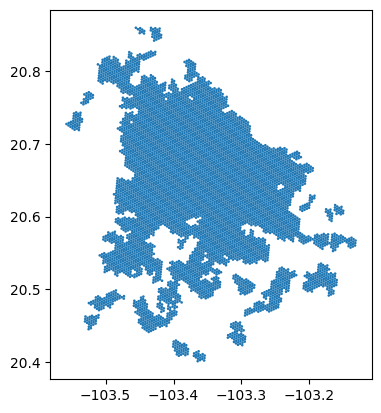

In [3]:
hex_gdf.plot()

### DENUE

In [4]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry('geometry')
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [5]:
folder_denue = 'denue'
table_denue = 'denue_23_point'

# download denue
query = f"SELECT * FROM {folder_denue}.{table_denue} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

denue = aup.gdf_from_query(query, geometry_col='geometry')

print(denue.shape)
denue.head(4)

(217868, 43)


,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta,geometry
0,1708588.0,14120316211000441001000000U8,BOTAS Y BOTINES 6 POTROS,None,316211,Fabricación de calzado con corte de piel y cuero,6 a 10 personas,PROLONGACION,LOS BELENES,PRIVADA,...,3698,3.0,None,None,None,Fijo,20.746290,-103.37448,2014-12,POINT (-103.37448 20.74629)
1,6146496.0,14120237212000041000000000U0,CONSTRUCCIONES ONCE,CONSTRUCCIONES ONCE SA DE CV,237212,Construcción de obras de urbanización,0 a 5 personas,CALLE,PASEO DE LOS COLORINES,CALLE,...,0994,6.0,None,None,None,Fijo,20.741459,-103.37159,2010-07,POINT (-103.37159 20.74146)
2,1709354.0,14120222111000091010014414S6,SIAPA TANQUE 1 TABACHINES,SISTEMA INTERMUNICIPAL DE LOS SERVICIOS DE AGU...,221312,"Captación, tratamiento y suministro de agua re...",0 a 5 personas,AVENIDA,DE LOS TABACHINES,CALLE,...,4200,5.0,None,JOSEA.RAMIREZ@SIAPA.GOB.MX,WWW.SIAPA.GOB.MX,Fijo,20.740303,-103.36987,2014-12,POINT (-103.36987 20.7403)
3,1708439.0,14120311520001281000000000U6,PALETERIA LA MICHOACANA,None,311520,Elaboración de helados y paletas,0 a 5 personas,CALLE,JARDINES DE LOS JAZMINES,CALZADA,...,1899,8.0,None,None,None,Fijo,20.748010,-103.37111,2014-12,POINT (-103.37111 20.74801)


### Censo

In [6]:
folder_censo = 'sociodemografico'
tabla_censo = 'censo_inegi_20_mza'

# download denue
query = f"SELECT * FROM {folder_censo}.{tabla_censo} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

mza_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mza_gdf = mza_gdf[['cvegeo_mza','pobtot','geometry']].copy()

print(mza_gdf.shape)
mza_gdf.head(4)

(54772, 3)


,cvegeo_mza,pobtot,geometry
0,1403900010149030,79,"POLYGON ((-103.34181 20.70307, -103.34184 20.7..."
1,1403900010365001,80,"POLYGON ((-103.34686 20.70102, -103.3468 20.70..."
2,1403900010365002,92,"POLYGON ((-103.34528 20.70128, -103.3454 20.70..."
3,1403900010365003,51,"POLYGON ((-103.34656 20.70041, -103.34664 20.7..."


In [7]:
mza_gdf = mza_gdf.to_crs("EPSG:6372")
mza_gdf['geometry'] = mza_gdf.centroid
mza_gdf = mza_gdf.to_crs("EPSG:4326")
mza_gdf['nombre_act'] = 'Habitacional'
mza_gdf = mza_gdf.rename(columns={'cvegeo_mza':'clee',
                                 'pobtot':'per_ocu_num'})

## Data treatment

In [8]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [9]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [10]:
denue['codigo_grl'] = denue.codigo_act.apply(lambda x: x[:-4])

In [11]:
clas_act = {'Industria':['31','32','33'],
           'Comercio':['43','46'],
           'Servicios':['52','53','54','55','56',
                       '72','81','93'],
            'Equipamiento':['61','62'],
            'Recreativo':['71'],
           'Otros':['11','21','22','23',
                    '51','48','49',],
           }

In [12]:
act_name = {}
for k,v in clas_act.items():
    for x in v:
        act_name.setdefault(x, []).append(k)

In [13]:
denue['nombre_act'] = denue.codigo_grl.apply(lambda x: act_name[x][0])

### Merge Pop and DENUE

In [14]:
mza_denue = pd.concat([denue[['clee','per_ocu_num','nombre_act','geometry']],
          mza_gdf])
print(mza_denue.shape)
mza_denue.head(2)

(272640, 4)


,clee,per_ocu_num,nombre_act,geometry
0,14120316211000441001000000U8,8,Industria,POINT (-103.37448 20.74629)
1,14120237212000041000000000U0,3,Otros,POINT (-103.37159 20.74146)


## Save data

In [15]:
hex_gdf.to_file('../../../data/processed/viviendas_tlajo/hex_gdl.geojson')
mza_denue.to_file('../../../data/processed/viviendas_tlajo/mza_denue_gdl.geojson')

## Area of Interest

In [26]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')
aoi_gdf = aoi_gdf.to_crs("EPSG:32613")
aoi_buffer = aoi_gdf.copy()
aoi_buffer = aoi_buffer.dissolve()
aoi_buffer['geometry'] = aoi_buffer.buffer(100)
print(aoi_buffer.shape)

(1, 11)


<Axes: >

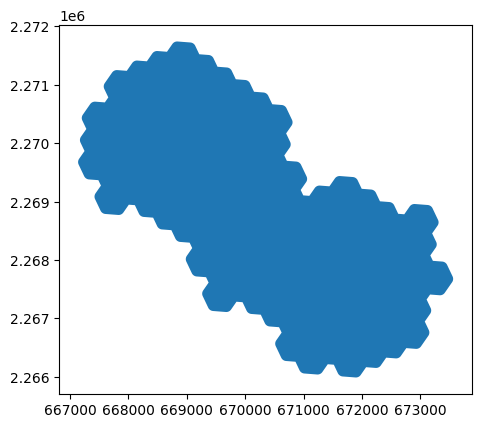

In [25]:
aoi_buffer.plot()

## Kernel density

In [16]:
from spatial_kde import spatial_kernel_density

In [28]:
kde_dir = '../../../data/processed/viviendas_tlajo/kde_output/'
radio = 100

In [30]:
for uso in mza_denue.nombre_act.unique():
    # Filtrar puntos DENUE dentro de la manzana y con la actividad deseada
    uso_point = mza_denue.loc[mza_denue.nombre_act==uso].copy()
    uso_point = uso_point.to_crs("EPSG:32613")
    uso_point = uso_point.clip(aoi_buffer)

    if uso_point.empty:
        continue

    # Nombre de salida con ID y nombre de actividad
    output_file = f"{kde_dir}kde_{uso}.tif"
    uso_point = uso_point.reset_index(drop=True)


    # Ejecutar el KDE
    spatial_kernel_density(
        points=uso_point,
        radius = radio,
        output_path=output_file,
        output_pixel_size=5.0,
        output_driver="GTiff",
        weight_col="per_ocu_num",
    )

### Kernel to hex

## Hex Uso de suelo

In [17]:
hex_usosuelo = gpd.read_file('../../../data/processed/viviendas_tlajo/hex_uso_suelo.geojson')
print(hex_usosuelo.shape)
hex_usosuelo.head(2)

DataSourceError: ../../../data/processed/viviendas_tlajo/hex_uso_suelo.geojson: No such file or directory

In [27]:
uso_list = ['comerciomean','equipmean','habmean',
           'indmean','otromean','recreativomean',
           'servmean']

In [28]:
hex_usosuelo['uso_tot'] = hex_usosuelo[uso_list].sum(axis=1)

In [29]:
for us in uso_list:
    hex_usosuelo['pct_'+us] = hex_usosuelo[us]/hex_usosuelo['uso_tot']

In [30]:
print(hex_usosuelo.shape)
hex_usosuelo.head(2)

(2826, 21)


,hex_id_9,CVEGEO,NOMGEO,city,type,comerciomean,equipmean,habmean,indmean,otromean,...,servmean,geometry,uso_tot,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.04298,0.0,561.548754,0.0,0.000000,...,0.0,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",561.591734,0.000077,0.0,0.999923,0.0,0.000000,0.0,0.0
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.00000,0.0,66.851812,0.0,0.285432,...,0.0,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",67.137244,0.000000,0.0,0.995749,0.0,0.004251,0.0,0.0


In [32]:
hex_usosuelo.to_file('../../../data/processed/Distrito_QRO/hex_pct_uso_suelo.geojson')